### Загрузка данных

Коллекция дана в json-формате: для каждого рецепта известны его id, кухня (cuisine) и список ингредиентов, в него входящих. Загрузить данные можно с помощью модуля json (он входит в дистрибутив Anaconda):

In [ ]:
import json
import pandas as pd

In [ ]:
pip install gensim

In [ ]:
with open("recipes.json") as f:
    recipes = json.load(f)

In [ ]:
print(recipes[0])

{'id': 10259, 'cuisine': 'greek', 'ingredients': ['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']}


### Составление корпуса

In [ ]:
from gensim import corpora, models
import numpy as np

Наша коллекция небольшая, и целиком помещается в оперативную память. Gensim может работать с такими данными и не требует их сохранения на диск в специальном формате. Для этого коллекция должна быть представлена в виде списка списков, каждый внутренний список соответствует отдельному документу и состоит из его слов. Пример коллекции из двух документов: 

[["hello", "world"], ["programming", "in", "python"]]

Преобразуем наши данные в такой формат, а затем создадим объекты corpus и dictionary, с которыми будет работать модель.

In [ ]:
texts = [recipe["ingredients"] for recipe in recipes]
dictionary = corpora.Dictionary(texts)   # составляем словарь
corpus = [dictionary.doc2bow(text) for text in texts]  # составляем корпус документов

In [ ]:
print(texts[0])
print(corpus[0])

['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]


У объекта dictionary есть полезная переменная dictionary.token2id, позволяющая находить соответствие между ингредиентами и их индексами.

### Обучение модели

In [ ]:
np.random.seed(76543)
# здесь код для построения модели:
%time ldamodel = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=40, passes=5)

CPU times: user 1min 4s, sys: 318 ms, total: 1min 4s
Wall time: 1min 4s


In [ ]:
top_topics = ldamodel.show_topics(num_topics=40, num_words=10)
ldamodel.show_topics(num_topics=40, num_words=10, formatted=True)

[(0,
  '0.084*"garlic cloves" + 0.070*"chopped onion" + 0.068*"cooking spray" + 0.065*"salt" + 0.043*"water" + 0.042*"fat free less sodium chicken broth" + 0.039*"ground red pepper" + 0.039*"sliced green onions" + 0.026*"black pepper" + 0.024*"pinenuts"'),
 (1,
  '0.076*"corn kernels" + 0.065*"diced onions" + 0.054*"tortillas" + 0.053*"salt and ground black pepper" + 0.049*"cream cheese" + 0.044*"1% low-fat milk" + 0.039*"vegetable stock" + 0.037*"sliced black olives" + 0.036*"cream cheese, soften" + 0.035*"chopped fresh chives"'),
 (2,
  '0.081*"olive oil" + 0.054*"fresh parsley" + 0.052*"crushed red pepper" + 0.042*"salt" + 0.041*"grated parmesan cheese" + 0.039*"garlic cloves" + 0.034*"cherry tomatoes" + 0.033*"low salt chicken broth" + 0.031*"butter" + 0.029*"green beans"'),
 (3,
  '0.074*"bacon" + 0.073*"salt" + 0.061*"red pepper flakes" + 0.047*"garlic" + 0.046*"ground black pepper" + 0.042*"pasta" + 0.037*"onions" + 0.037*"olive oil" + 0.036*"chicken thighs" + 0.030*"fresh dill"

In [ ]:
top_topics[21]

(21,
 '0.209*"chicken broth" + 0.086*"boneless skinless chicken breast halves" + 0.078*"boneless skinless chicken breasts" + 0.056*"cajun seasoning" + 0.037*"juice" + 0.030*"butter" + 0.030*"pepper" + 0.025*"onions" + 0.022*"garlic salt" + 0.021*"boneless chicken breast"')

In [ ]:
c_salt = 0
c_sugar = 0
c_water = 0
c_mushrooms = 0
c_chicken = 0
c_eggs = 0

for t, top_words in top_topics:
  c_salt += top_words.count('"salt"')
  c_sugar += top_words.count('"sugar"')
  c_water += top_words.count('"water"')
  c_mushrooms += top_words.count('"mushrooms"')
  c_chicken += top_words.count('"chicken"')
  c_eggs += top_words.count('"eggs"')

print(c_salt, c_sugar, c_water, c_mushrooms, c_chicken, c_eggs)

23 9 10 0 1 2


In [ ]:
def save_answers1(c_salt, c_sugar, c_water, c_mushrooms, c_chicken, c_eggs):
    with open("./cooking_LDA_pa_task1.txt", "w") as fout:
        fout.write(" ".join([str(el) for el in [c_salt, c_sugar, c_water, c_mushrooms, c_chicken, c_eggs]]))

In [ ]:
save_answers1(c_salt, c_sugar, c_water, c_mushrooms, c_chicken, c_eggs)

### Фильтрация словаря
В топах тем гораздо чаще встречаются первые три рассмотренных ингредиента, чем последние три. При этом наличие в рецепте курицы, яиц и грибов яснее дает понять, что мы будем готовить, чем наличие соли, сахара и воды. Таким образом, даже в рецептах есть слова, часто встречающиеся в текстах и не несущие смысловой нагрузки, и поэтому их не желательно видеть в темах. Наиболее простой прием борьбы с такими фоновыми элементами — фильтрация словаря по частоте. Обычно словарь фильтруют с двух сторон: убирают очень редкие слова (в целях экономии памяти) и очень частые слова (в целях повышения интерпретируемости тем). Мы уберем только частые слова.

In [ ]:
import copy
dictionary2 = copy.deepcopy(dictionary)

In [ ]:
keys = [dictionary2[k] for k, v in dictionary2.dfs.items() if v>4000]

In [ ]:
items = [dictionary2.token2id[k] for k in keys]
items

[3, 5, 15, 11, 18, 20, 29, 44, 52, 59, 104, 114]

In [ ]:
dictionary2.filter_tokens(bad_ids=items)

In [ ]:
dict_size_before = len(dictionary)
dict_size_after = len(dictionary2)

In [ ]:
corpus2 = [dictionary2.doc2bow(text) for text in texts]
corpus_size_after = []
for i in range(len(corpus2)):
  corpus_size_after.append(len(corpus2[i]))

In [ ]:
corpus_size_before = []
for i in range(len(corpus)):
  corpus_size_before.append(len(corpus[i]))

In [ ]:
print(sum(corpus_size_after))
print(sum(corpus_size_before))

343665
428249


In [ ]:
def save_answers2(dict_size_before, dict_size_after, corpus_size_before, corpus_size_after):
    with open("cooking_LDA_pa_task2.txt", "w") as fout:
        fout.write(" ".join([str(el) for el in [dict_size_before, dict_size_after, corpus_size_before, corpus_size_after]]))

In [ ]:
save_answers2(dict_size_before, dict_size_after, sum(corpus_size_before), sum(corpus_size_after))

### Сравнение когерентностей

In [ ]:
np.random.seed(76543)
# здесь код для построения модели:
%time ldamodel2 = models.ldamodel.LdaModel(corpus2, id2word=dictionary2, num_topics=40, passes=5)

CPU times: user 52.7 s, sys: 314 ms, total: 53 s
Wall time: 52.9 s


In [ ]:
avr_cog2 = sum([ldamodel2.top_topics(corpus2)[i][1] for i in range(len(ldamodel2.top_topics(corpus2)))])/len(ldamodel2.top_topics(corpus2))

In [ ]:
avr_cog = sum([ldamodel.top_topics(corpus)[i][1] for i in range(len(ldamodel2.top_topics(corpus)))])/len(ldamodel2.top_topics(corpus))

In [ ]:
def save_answers3(coherence, coherence2):
    with open("cooking_LDA_pa_task3.txt", "w") as fout:
        fout.write(" ".join(["%3f"%el for el in [coherence, coherence2]]))

In [ ]:
save_answers3(avr_cog, avr_cog2)

In [ ]:
print(avr_cog, avr_cog2)

-5.849971009856025 -8.304104910059584


Считается, что когерентность хорошо соотносится с человеческими оценками интерпретируемости тем. Поэтому на больших текстовых коллекциях когерентность обычно повышается, если убрать фоновую лексику. Однако в нашем случае этого не произошло. 

### Изучение влияния гиперпараметра alpha

In [ ]:
ldamodel2.get_document_topics(corpus[0])

[(4, 0.20250002), (25, 0.1025), (30, 0.10711076), (31, 0.49788922)]

Также выведите содержимое переменной *.alpha* второй модели:

In [ ]:
ldamodel2.alpha

array([0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025], dtype=float32)

In [ ]:
np.random.seed(76543)
# здесь код для построения модели:
%time ldamodel3 = models.ldamodel.LdaModel(corpus2, id2word=dictionary2, num_topics=40, passes=5, alpha=1)

CPU times: user 38.6 s, sys: 465 ms, total: 39.1 s
Wall time: 38.8 s


In [ ]:
count_model3 = sum([len(ldamodel3.get_document_topics(corpus2[i], minimum_probability=0.01)) for i in range(len(corpus2))])

In [ ]:
count_model2 = sum([len(ldamodel2.get_document_topics(corpus2[i], minimum_probability=0.01)) for i in range(len(corpus2))])

In [ ]:
def save_answers4(count_model2, count_model3):
    with open("cooking_LDA_pa_task4.txt", "w") as fout:
        fout.write(" ".join([str(el) for el in [count_model2, count_model3]]))

In [ ]:
save_answers4(count_model2, count_model3)

Таким образом, гиперпараметр __alpha__ влияет на разреженность распределений тем в документах. Аналогично гиперпараметр __eta__ влияет на разреженность распределений слов в темах.

### LDA как способ понижения размерности

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
ldamodel2.get_document_topics(corpus2[0])

[(25, 0.12812501), (30, 0.13389271), (31, 0.6223573)]

In [ ]:
y = []
for r in recipes:
    y.append(r['cuisine'])

In [ ]:
X = np.zeros((len(recipes),40))
for i in range(len(recipes)):
    top = ldamodel2.get_document_topics(corpus2[i])
    for t in top:
        X[i,t[0]] = t[1]
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.00000,0.00000,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.000000,0.000000,0.0000,0.0000,0.00000,0.000000,0.000000,0.000000,0.128125,0.000000,0.0000,0.000000,0.000000,0.133891,0.622359,0.000000,0.0000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.113889,0.447131,0.0000,0.0000,0.0000,0.0000,0.11398,0.00000,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.000000,0.000000,0.0000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,0.0000,0.000000,0.225000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.00000,0.00000,0.105373,0.000000,0.0000,0.0000,0.102500,0.0000,0.114786,0.000000,0.0000,0.0000,0.10250,0.173595,0.177291,0.000000,0.000000,0.000000,0.0000,0.000000,0.103528,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,0.0000,0.000000,0.040427
3,0.012500,0.012500,0.012500,0.012500,0.012500,0.0125,0.0125,0.0125,0.0125,0.01250,0.01250,0.512500,0.012500,0.0125,0.0125,0.012500,0.0125,0.012500,0.012500,0.0125,0.0125,0.01250,0.012500,0.012500,0.012500,0.012500,0.012500,0.0125,0.012500,0.012500,0.012500,0.012500,0.012500,0.0125,0.0125,0.012500,0.012500,0.0125,0.012500,0.012500
4,0.000000,0.106841,0.000000,0.000000,0.057080,0.0000,0.0000,0.0000,0.0000,0.00000,0.23897,0.000000,0.000000,0.0000,0.0000,0.075129,0.0000,0.000000,0.000000,0.0000,0.0000,0.39923,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.072750,0.0000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39769,0.000000,0.000000,0.102500,0.000000,0.157653,0.0000,0.0000,0.0000,0.0000,0.00000,0.00000,0.000000,0.121801,0.0000,0.0000,0.000000,0.0000,0.000000,0.000000,0.0000,0.0000,0.10250,0.000000,0.000000,0.000000,0.000000,0.000000,0.1025,0.000000,0.000000,0.128046,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,0.0000,0.102500,0.102500
39770,0.128125,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.00000,0.00000,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.000000,0.000000,0.0000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.128125,0.128125,0.378125,0.000000,0.128125,0.0000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000
39771,0.000000,0.000000,0.000000,0.123921,0.313014,0.0000,0.0000,0.0000,0.0000,0.00000,0.00000,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.000000,0.259258,0.0000,0.0000,0.00000,0.112936,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,0.0000,0.103370,0.000000
39772,0.000000,0.000000,0.000000,0.000000,0.096644,0.0000,0.0000,0.0000,0.0000,0.00000,0.00000,0.000000,0.056605,0.0000,0.0000,0.054042,0.0000,0.000000,0.000000,0.0000,0.0000,0.00000,0.057175,0.433090,0.000000,0.000000,0.000000,0.0000,0.045850,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.049884,0.050196,0.0000,0.050827,0.069973


In [ ]:
RandomForest = RandomForestClassifier(n_estimators=100)

In [ ]:
accuracy = cross_val_score(RandomForest, X, y=y, cv=3)

In [ ]:
accuracy = accuracy.mean()
accuracy

0.5551616633981998

In [ ]:
def save_answers5(accuracy):
     with open("cooking_LDA_pa_task5.txt", "w") as fout:
        fout.write(str(accuracy))

In [ ]:
save_answers5(accuracy)

Для такого большого количества классов это неплохая точность. Вы можете попроовать обучать RandomForest на исходной матрице частот слов, имеющей значительно большую размерность, и увидеть, что accuracy увеличивается на 10–15%. Таким образом, LDA собрал не всю, но достаточно большую часть информации из выборки, в матрице низкого ранга.

### LDA — вероятностная модель
Матричное разложение, использующееся в LDA, интерпретируется как следующий процесс генерации документов.

Для документа $d$ длины $n_d$:
1. Из априорного распределения Дирихле с параметром alpha сгенерировать распределение над множеством тем: $\theta_d \sim Dirichlet(\alpha)$
1. Для каждого слова $w = 1, \dots, n_d$:
    1. Сгенерировать тему из дискретного распределения $t \sim \theta_{d}$
    1. Сгенерировать слово из дискретного распределения $w \sim \phi_{t}$.
    
Подробнее об этом в [Википедии](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation).

В контексте нашей задачи получается, что, используя данный генеративный процесс, можно создавать новые рецепты. Вы можете передать в функцию модель и число ингредиентов и сгенерировать рецепт :)

In [ ]:
def generate_recipe(model, num_ingredients):
    theta = np.random.dirichlet(model.alpha)
    for i in range(num_ingredients):
        t = np.random.choice(np.arange(model.num_topics), p=theta)
        topic = model.show_topic(t, topn=model.num_terms)
        topic_distr = [x[1] for x in topic]
        terms = [x[0] for x in topic]
        p = np.array(topic_distr)
        topic_distr /= sum(topic_distr)
        w = np.random.choice(terms, p=p)
        print(w)

In [ ]:
generate_recipe(ldamodel2, 5)

Shaoxing wine
fresh parsley
bread
roasted red peppers
shallots


### Интерпретация построенной модели

In [ ]:
import pandas
import seaborn
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
def compute_topic_cuisine_matrix(model, corpus, recipes):

    targets = list(set([recipe["cuisine"] for recipe in recipes]))

    tc_matrix = pandas.DataFrame(data=np.zeros((model.num_topics, len(targets))), columns=targets)
    for recipe, bow in zip(recipes, corpus):
        recipe_topic = model.get_document_topics(bow)
        for t, prob in recipe_topic:
            tc_matrix[recipe["cuisine"]][t] += prob

    target_sums = pandas.DataFrame(data=np.zeros((1, len(targets))), columns=targets)
    for recipe in recipes:
        target_sums[recipe["cuisine"]] += 1
    return pandas.DataFrame(tc_matrix.values/target_sums.values, columns=tc_matrix.columns)

In [ ]:
def plot_matrix(tc_matrix):
    plt.figure(figsize=(10, 10))
    seaborn.heatmap(tc_matrix, square=True)

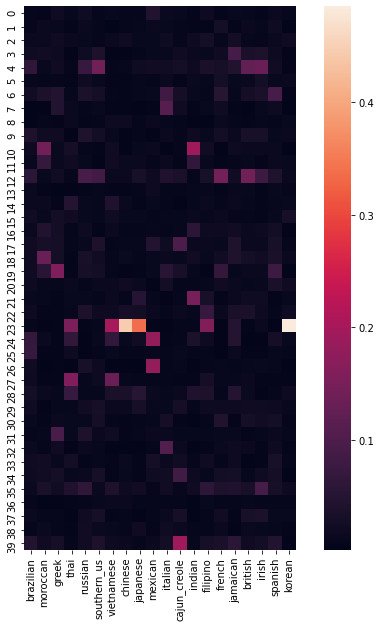

In [ ]:
matr1 = compute_topic_cuisine_matrix(ldamodel2, corpus2, recipes)
plot_matrix(matr1)

Чем темнее квадрат в матрице, тем больше связь этой темы с данной кухней. Мы видим, что у нас есть темы, которые связаны с несколькими кухнями. Такие темы показывают набор ингредиентов, которые популярны в кухнях нескольких народов, то есть указывают на схожесть кухонь этих народов. Некоторые темы распределены по всем кухням равномерно, они показывают наборы продуктов, которые часто используются в кулинарии всех стран. 

Жаль, что в датасете нет названий рецептов, иначе темы было бы проще интерпретировать...